In [2]:
# 模块导入
import pandas as pd
import torch
import os
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
from tqdm import tqdm
from wordcloud import WordCloud
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler
from torch import nn, optim


In [3]:
data_train = pd.read_csv("nCoV_100k_train_labled.csv")
data_test = pd.read_csv("nCoV_10k_test.csv")

print(data_train.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   微博id    100000 non-null  int64 
 1   微博发布时间  100000 non-null  object
 2   发布人账号   100000 non-null  object
 3   微博中文内容  99646 non-null   object
 4   微博图片    100000 non-null  object
 5   微博视频    100000 non-null  object
 6   情感倾向    99919 non-null   object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   微博id    10000 non-null  int64 
 1   微博发布时间  10000 non-null  object
 2   发布人账号   10000 non-null  object
 3   微博中文内容  9963 non-null   object
 4   微博图片    10000 non-null  object
 5   微博视频    10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB
None


In [4]:
data_train = data_train[['微博id', '微博中文内容', '情感倾向']]
data_test = data_test[['微博id', '微博中文内容']]
data_train.columns = ['id', 'content', 'y']
data_test.columns = ['id', 'content']
data_train

,id,content,y
0,4456072029125500,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0
1,4456074167480980,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1
2,4456054253264520,�偳癯空饩褪俏业�，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，...,1
3,4456061509126470,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1
4,4455979322528190,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1
...,...,...,...
99995,4473033438259880,#抗击新型肺炎第一线#【@中国计量大学研制新冠病毒蛋白标准样品】记者从中国计量大学获悉，新型...,0
99996,4472969222714290,1、类RaTG13病毒（一种从云南蝙蝠身上分离出来的冠状病毒）可能是2019-nCoV的源头...,0
99997,4473035904435920,#微博辟谣#没有证据表明，吃大蒜、漱口水、涂抹芝麻油、生理盐水洗鼻子等手段可以防止感染新型冠...,0
99998,4472950743017610,【新冠疫情最受关注的十一篇英文核心期刊论文全解析】本文整理了关于新型冠状病毒最受关注的十一篇...,1


In [5]:
def clean_data(x):
    x = str(x)
    x = x.replace('\n', ' ')
    x = x.replace('\r', '')
    x = x.replace('\t', ' ')
    x = x.replace('展开全文', '')
    return x

data_train['content'] = data_train['content'].apply(clean_data)
data_test['content'] = data_test['content'].apply(clean_data)
data_train['text_len'] = data_train['content'].apply(len)
data_test['text_len'] = data_test['content'].apply(len)
data_train

,id,content,y,text_len
0,4456072029125500,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早...,0,143
1,4456074167480980,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,-1,47
2,4456054253264520,�偳癯空饩褪俏业�，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，...,1,100
3,4456061509126470,新年的第一天感冒又发烧的也太衰了但是我要想着明天一定会好的?,1,30
4,4455979322528190,问：我们意念里有坏的想法了，天神就会给记下来，那如果有好的想法也会被记下来吗？答：那当然了。...,1,141
...,...,...,...,...
99995,4473033438259880,#抗击新型肺炎第一线#【@中国计量大学研制新冠病毒蛋白标准样品】记者从中国计量大学获悉，新型...,0,146
99996,4472969222714290,1、类RaTG13病毒（一种从云南蝙蝠身上分离出来的冠状病毒）可能是2019-nCoV的源头...,0,144
99997,4473035904435920,#微博辟谣#没有证据表明，吃大蒜、漱口水、涂抹芝麻油、生理盐水洗鼻子等手段可以防止感染新型冠...,0,62
99998,4472950743017610,【新冠疫情最受关注的十一篇英文核心期刊论文全解析】本文整理了关于新型冠状病毒最受关注的十一篇...,1,102


In [6]:
x_range = [i for i in range(250)]
train_distribution = np.zeros(250)
test_distribution = np.zeros(250)

data_train['text_len'].apply(lambda x: train_distribution.__setitem__(x - 1, train_distribution[x -1] + 1))
data_test['text_len'].apply(lambda x: test_distribution.__setitem__(x - 1, test_distribution[x -1] + 1))

0       None
1       None
2       None
3       None
4       None
        ... 
9995    None
9996    None
9997    None
9998    None
9999    None
Name: text_len, Length: 10000, dtype: object

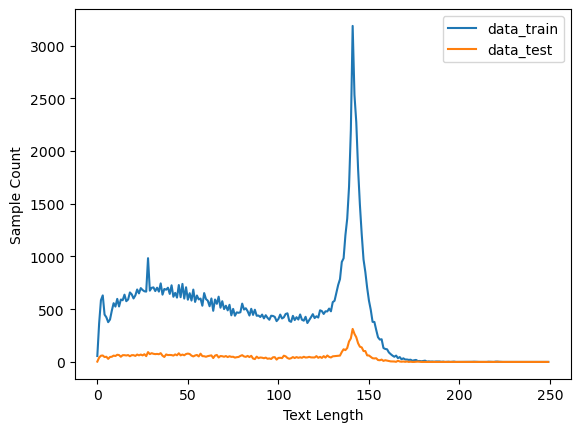

In [7]:
# 查看文本长度分布情况
fig, ax = plt.subplots()
ax.plot(x_range, train_distribution, label='data_train')
ax.plot(x_range, test_distribution, label='data_test')
ax.set_xlabel('Text Length')
ax.set_ylabel('Sample Count')
ax.legend()

plt.show()

In [8]:
# 清理缺失、错误标签
# 这里为方便直接删除，整体上不影响
nul_index =  data_train.loc[~data_train['y'].isin(['0', '-1', '1'])].index
data_train.drop(nul_index, inplace=True)
data_train['y'] = data_train['y'].astype(int)

<Axes: >

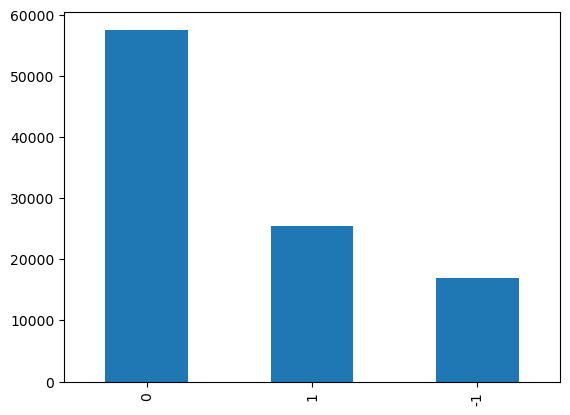

In [18]:
# 查看每一类的样本密度
data_train['y'].value_counts().plot(kind='bar')

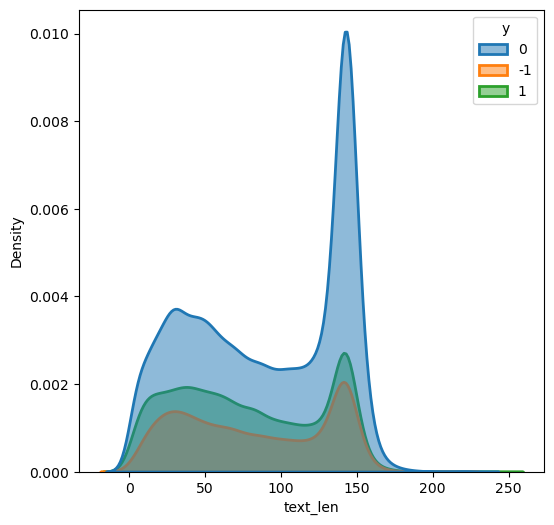

In [10]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 6))
sns.kdeplot(data = data_train, x = 'text_len', hue = 'y', fill = True, ax = ax, alpha = 0.5, linewidth = 2)
plt.show()

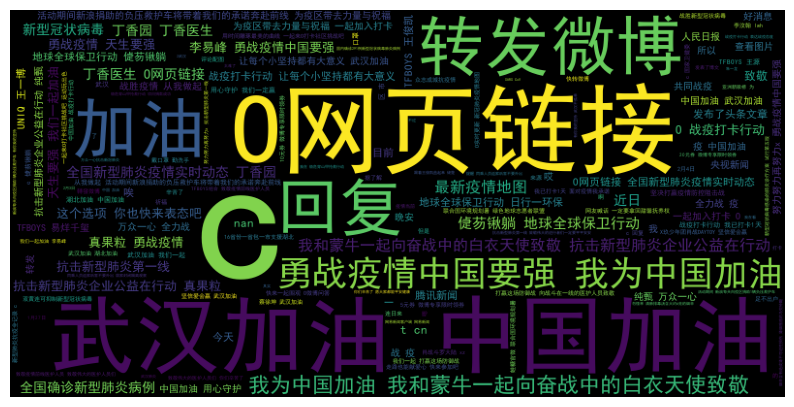

In [12]:
# 绘制词云图
text = " ".join(data_train['content'])
wordcloud = WordCloud(width=800, height=400, font_path = 'simhei.ttf').generate(text)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
class Config:
    num_classes = 3
    lr = 1e-3
    batch_size = 16
    shuffle = True
    epoch = 5
    num_workers = -1
    scheduler_step_size = 5
    scheduler_gamma = 0.9
    max_seq_len = 256
    model_name = 'hfl/chinese-bert-wwm-ext'

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_save_dir = './model' 
    model_save_name = 'bert.pt'
    
    # training parameters
    num_epochs = 5
    snapshots = 5
    useTest = True
    test_interval = 1

class TextDataset(Dataset):
    def __init__(self, texts: list | np.ndarray, labels: list | np.ndarray):
        self.texts = texts
        self.labels = labels

    def __getitem__(self, idx: int) -> tuple[str, int]:
        text_i = self.texts[idx]
        label_i = self.labels[idx]
        return text_i, label_i

    def __len__(self) -> int:
        assert len(self.texts) == len(self.labels)
        return len(self.labels)

def collate_fn(text_label: tuple[str, int]):
    tokenizer = BertTokenizer.from_pretrained(Config.model_name)
    texts = [text for text, _ in text_label]
    labels = [label for _, label in text_label]
    # The padding length can't surpass the max sequence length
    max_len = min(max([len(text) for text in texts]) + 2, Config.max_seq_len)

    data = tokenizer.batch_encode_plus(batch_text_or_text_pairs = texts, 
                                       add_special_tokens = True,       # add [CLS], [SEP], [EOP]
                                       padding = 'max_length', 
                                       truncation = True, 
                                       max_length = max_len,
                                       return_tensors = 'pt',
                                       return_token_type_ids = True,
                                       return_attention_mask = True,)
    inputs_ids = data['input_ids']
    attention_mask = data['attention_mask']     # mask the padding value
    token_type_ids = data['token_type_ids']
    labels = torch.LongTensor(labels)
    return inputs_ids, attention_mask, token_type_ids, labels

class BertClassifier(nn.Module):
    def __init__(self, hiddent_size: int, num_classes: int, model_name: str = Config.model_name) -> None:
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.fc = nn.Linear(hiddent_size, num_classes)
        # self.drop = nn.Dropout(p=0.3)
        # self.out = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        with torch.no_grad():
            out = self.bert(input_ids = input_ids, 
                            attention_mask = attention_mask, 
                            token_type_ids = token_type_ids)
            # out->(batch_size, seq_len, hidden_size)
            # we just need the first row, which is stand for the label
            prediction = self.fc(out.last_hidden_state[:, 0, :].to(Config.device))
            return prediction

# 导入模型
X_train, X_test, y_train, y_test = train_test_split(data_train['content'].tolist(), data_train['y'].tolist(), test_size = 0.2, random_state = 42)
train_loader = DataLoader(TextDataset(X_train, labels = y_train), 
                        batch_size = Config.batch_size, collate_fn = collate_fn, shuffle = Config.shuffle)
test_loader = DataLoader(TextDataset(X_test, labels = y_test), 
                        batch_size = Config.batch_size, collate_fn = collate_fn, shuffle = Config.shuffle)

In [19]:
def train():
    
    model = BertClassifier(hiddent_size = 768, num_classes = Config.num_classes)
    optimizer = optim.AdamW(model.parameters(), lr = Config.lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = Config.scheduler_step_size, gamma = Config.scheduler_gamma)
    
    model.to(Config.device)
    criterion.to(Config.device)

    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)

    for epoch in range(Config.num_epochs):
        running_loss = 0.0
        running_corrects = 0.0

        model.train()
        start_time = timeit.default_timer()
        for input_ids, attention_mask, token_type_ids, labels in tqdm(train_loader):
            input_ids = input_ids.to(Config.device)
            attention_mask = attention_mask.to(Config.device)
            token_type_ids = token_type_ids.to(Config.device)
            labels = labels.to(Config.device)

            prediction = model(input_ids = input_ids, 
                               attention_mask = attention_mask, 
                               token_type_ids = token_type_ids)
            print('prediction: ', prediction)
            print('labels: ', labels)
            loss = criterion(prediction, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            scheduler.step()
            prediction = prediction.detach().cpu().numpy().argmax(axis = 1)

            running_loss += loss.item() * input_ids.size(0)
            running_corrects += torch.sum(prediction == labels.data)

            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")

        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects.double() / train_size
        print(f"Epoch: {epoch + 1} | Loss: {epoch_loss} | Accuracy: {epoch_acc}")

        if (epoch + 1) % Config.snapshots == 0:
            if not os.path.exists(Config.model_save_dir):
                os.makedirs(Config.model_save_dir)
            save_path = os.path.join(Config.model_save_dir, Config.model_save_name + '_epoch-' + str(epoch) + '.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'opt_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
                'accuracy': epoch_acc,
            })
            print("Save model at {}\n".format(save_path))

        if Config.useTest and epoch % Config.test_interval == (Config.test_interval - 1):
            model.eval()
            start_time = timeit.default_timer()

            running_loss = 0.0
            running_corrects = 0.0

            for input_ids, attention_mask, token_type_ids in tqdm(test_loader):
                input_ids = input_ids.to(Config.device)
                attention_mask = attention_mask.to(Config.device)
                token_type_ids = token_type_ids.to(Config.device)
                labels = labels.to(Config.device)

                with torch.no_grad():
                    prediction = model(input_ids = input_ids, 
                                        attention_mask = attention_mask, 
                                        token_type_ids = token_type_ids)

                loss = criterion(prediction, labels)
                prediction = prediction.detach().cpu().numpy().argmax(axis = 1)


                running_loss += loss.item() * input_ids.size(0)
                running_corrects += torch.sum(prediction == labels.data)

            epoch_loss = running_loss / test_size
            epoch_acc = running_corrects.double() / test_size

            print("[test] Epoch: {}/{} Loss: {} Acc: {}".format(epoch+1, Config.num_epochs, epoch_loss, epoch_acc))
            stop_time = timeit.default_timer()
            print("Execution time: " + str(stop_time - start_time) + "\n")


train()

Some weights of the model checkpoint at hfl/chinese-bert-wwm-ext were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
data_train[['y']] += 1
data_train.loc[:, 'y']

0        1
1        0
2        2
3        2
4        2
        ..
99995    1
99996    1
99997    1
99998    2
99999    1
Name: y, Length: 99913, dtype: int32